In [1]:
from glob import glob
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
# CNN Building Tools below-these lines are causing problems in the code for some reason
import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras import backend as K
# from images.ipynb import load_images
from keras.backend import clear_session

In [2]:
df = []
df = pd.read_csv("HAM10000_metadata.csv")

lesion_type_dict = {
    "nv": "Melanocytic nevi",
    "mel": "Melanoma",
    "bkl": "Benign keratosis-like lesions",
    "akiec": "Actinic keratoses",
    "vasc": "Vascular lesions",
    "df": "Dermatofibroma",
    "bcc": "Basal Cell Carcinoma",
}

In [3]:
# features and target variables for train test split
# features = df[["dx_type", "age", "sex", "localization", "img"]]
features = np.load("images.npy")
target = df[["dx"]]

In [4]:
target = pd.get_dummies(target, columns=["dx"])

In [5]:
# train test data split
# x_train, x_test, y_train, y_test = train_test_split(
#     features, target, test_size=0.20, random_state=42
# )

# validation and train data split
# x_train, x_validate, y_train, y_validate = train_test_split(
#     x_train, y_train, test_size=0.1, random_state=42
# )
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
print(target.head())

   dx_akiec  dx_bcc  dx_bkl  dx_df  dx_mel  dx_nv  dx_vasc
0         0       0       0      0       0      1        0
1         0       0       0      0       0      1        0
2         0       0       0      0       0      1        0
3         0       0       0      0       0      1        0
4         0       0       0      0       1      0        0


In [7]:
# Start of CNN Building
input_shape = (99, 99, 3)
num_classes = 7

In [8]:
# Initialising the CNN
model = Sequential()
# Adding layers to the model
model.add(
    Conv2D(
        32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        input_shape=input_shape,
    )
)

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="Same"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation="relu", padding="Same"))
model.add(Conv2D(64, (3, 3), activation="relu", padding="Same"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))


model.add(Conv2D(64, (3, 3), activation="relu", padding="Same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="Same"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(Flatten())
# model.add(Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 99, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 99, 99, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 49, 49, 64)        36928     
                                                        

In [9]:
# Define the optimizer
# optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
# Compile the model
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005), loss = "categorical_crossentropy", metrics=["accuracy"])
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [10]:
# Code adds artificial data, to be used after first draft of model is complete

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip image

# datagen.fit(x_train)

In [11]:
epochs = 5
batch_size = 100
history = model.fit(x_train,y_train, batch_size=batch_size, epochs = epochs, validation_data = (x_validate,y_validate), verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, callbacks=[learning_rate_reduction])

Epoch 1/5


  2/143 [..............................] - ETA: 4:56 - loss: 43.2202 - accuracy: 0.1750

KeyboardInterrupt: 

Text(0, 0.5, 'Error')

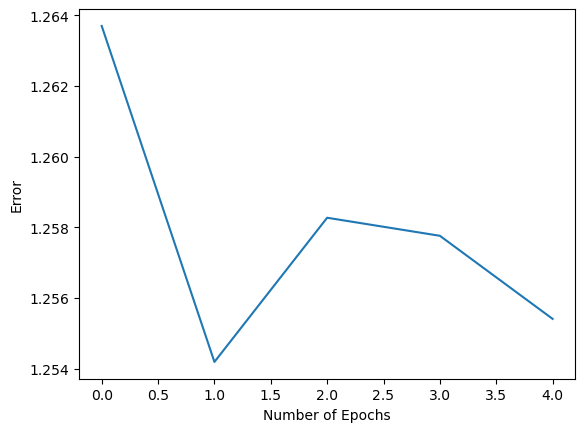

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.xlabel("Number of Epochs")
plt.ylabel("Error")